In [81]:
%reload_ext autoreload
%autoreload 2

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Monday, January 8 2018 at 11AM (Bangalore Time).


    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---

Map partitions for kmeans

Spark note book for HHP

# Knowledge check: Short answer questions 

__What is Apache Spark and how is it different to Apache Hadoop? __

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, ___ BLANKS __ languages (list languages). __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or ????? in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. What is a dataframe? Name one difference between a dataframe and an RDD record?

<hr>


# Word Counts and secondary sorts in Spark

### Save data to disk 

In [ ]:
%%writefile wordcount.txt
hello hi hi hallo
bonjour hola hi ciao
hill hill hail halo
hall hall hail halo
nihao konnichiwa ola
hola nihao hello

In [ ]:
cat wordcount.txt

## NOTES on Inputs to Spark

http://spark.apache.org/docs/latest/programming-guide.html
All of Spark’s file-based input methods, including textFile, support running on directories, compressed files, and wildcards as well. For example, you can use 

> textFile("/my/directory"), <p>

> textFile("/my/directory/*.txt"), and <P>

> textFile("hdfs://my/directory/*.txt"), and <P>
> textFile("/my/directory/*.gz").

The textFile method also takes an optional second argument for controlling the number of partitions of the file. By default, Spark creates one partition for each block of the file (blocks being 64MB by default in HDFS), but you can also ask for a higher number of partitions by passing a larger value. Note that you cannot have fewer partitions than blocks.

In [7]:
rdd.first()

u'hello hi hi hallo'

## Mapper-only job (for debugging the mapper inside Spark)

In [10]:
#def lineSplitter(line):
#    line.split(" ")
#lineSplitter("helllo ni hao....")
#Count words in file/directory
logFileNAME = 'wordcount.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) 
             
wordCounts = counts.collect()
for v in counts.collect():
    print v

(u'hello', 1)
(u'hi', 1)
(u'hi', 1)
(u'hallo', 1)
(u'bonjour', 1)
(u'hola', 1)
(u'hi', 1)
(u'ciao', 1)
(u'nihao', 1)
(u'konnichiwa', 1)
(u'ola', 1)
(u'hola', 1)
(u'nihao', 1)
(u'hello', 1)


In [11]:
#Count words in file/directory
logFileNAME = 'wordcount.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)
wordCounts = counts.collect()
for v in counts.collect():
    print v

(u'ciao', 1)
(u'bonjour', 1)
(u'nihao', 2)
(u'hola', 2)
(u'konnichiwa', 1)
(u'hallo', 1)
(u'hi', 3)
(u'hello', 2)
(u'ola', 1)


In [8]:
print wordCounts

[(u'ciao', 1), (u'bonjour', 1), (u'nihao', 2), (u'hola', 2), (u'konnichiwa', 1), (u'hallo', 1), (u'hi', 3), (u'hello', 2), (u'ola', 1)]


## General purpose Plotting function for BarPlots

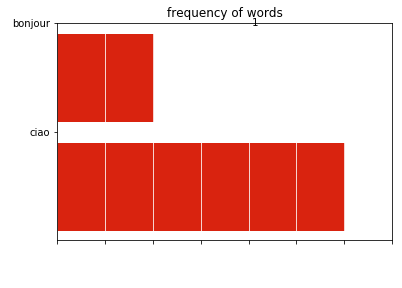

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

# this is general purpose code to produce a barplot from a list like
# See Unit test below for an example use case

def myBarPlot(dimensionMeasureList, measureStr):
    """
    Show a bar chart of the total measure per item
    """
    items = [d[0] for d in dimensionMeasureList]
    minutes  = [d[1] for d in dimensionMeasureList]
    index    = list(xrange(len(items)))

    fig, axe = plt.subplots()
    bars = axe.barh(index, minutes)

    # Add the total measure (e.g., wordcount) to the right
    for idx, air, min in zip(index, items, minutes):
        if min > 0:
            bars[idx].set_color('#d9230f')
            axe.annotate(" %0.0f" % min, xy=(min+1, idx+0.5), va='center')
        else:
            bars[idx].set_color('#469408')
            axe.annotate(" %0.0f" % min, xy=(10, idx+0.5), va='center')

    # Set the ticks
    ticks = plt.yticks([idx+ 0.5 for idx in index], items)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))

    #minimize chartjunk
    plt.grid(axis = 'x', color ='white', linestyle='-')

    plt.title(measureStr)
    plt.show()


#  Unit test for myBarPlot
myBarPlot([(u'hallo', 5), (u'konnichiwa', 4), (u'ola', 3), (u'ciao', 3), (u'bonjour', 1)][3:] , 
          "frequency of words")

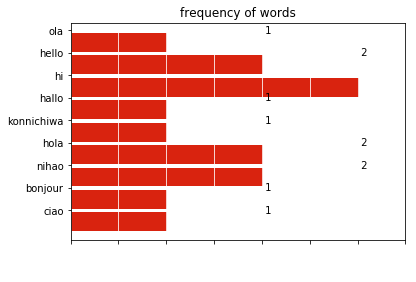

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

# this is general purpose code to produce a barplot from a list like
# wordCounts = [(u'hallo', 1),
#  (u'konnichiwa', 1),
#  (u'ola', 1),
#  (u'ciao', 1),
#  (u'bonjour', 1),
#  (u'nihao', 2),
#  (u'hello', 2),
#  (u'hola', 2),
#  (u'hi', 3)]
#  to Call use 
#   plot(wordCounts[:10], "frequency of words")

def plot(delays, measureStr):
    """
    Show a bar chart of the total delay per airline
    """
    airlines = [d[0] for d in delays]
    measures  = [d[1] for d in delays]
    index    = list(xrange(len(airlines)))

    fig, axe = plt.subplots()
    bars = axe.barh(index, measures)

    # Add the total minutes to the right
    for idx, air, min in zip(index, airlines, measures):
        if min > 0:
            bars[idx].set_color('#d9230f')
            axe.annotate(" %0.0f" % min, xy=(min+1, idx+0.5), va='center')
        else:
            bars[idx].set_color('#469408')
            axe.annotate(" %0.0f" % min, xy=(10, idx+0.5), va='center')

    # Set the ticks
    ticks = plt.yticks([idx+ 0.5 for idx in index], airlines)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))

    #minimize chartjunk
    plt.grid(axis = 'x', color ='white', linestyle='-')

    plt.title(measureStr)
    plt.show()


#  E.g., Call
plot(wordCounts[:10], "frequency of words")

__sortByKey([ascending], [numTasks])__	

When called on a dataset of (K, V) pairs where K implements Ordered, returns a dataset of (K, V) pairs sorted by keys in ascending or descending order, as specified in the boolean ascending argument.

In [13]:
wordCounts

[(u'ciao', 1),
 (u'bonjour', 1),
 (u'nihao', 2),
 (u'hola', 2),
 (u'konnichiwa', 1),
 (u'hallo', 1),
 (u'hi', 3),
 (u'hello', 2),
 (u'ola', 1)]

In [14]:
#Last 1
wordCounts[8:]

[(u'ola', 1)]

In [15]:
#first  5
wordCounts[:5]

[(u'ciao', 1),
 (u'bonjour', 1),
 (u'nihao', 2),
 (u'hola', 2),
 (u'konnichiwa', 1)]

## Quiz: Part 1: Modify the code to sort the word count records in decreasing order of frequency and plot

### your code should procuce something like this
>[(u'hi', 3)
(u'nihao', 2)
(u'hello', 2)
(u'hola', 2)
(u'hall', 2)
....
(u'hallo', 1)
(u'konnichiwa', 1)
(u'ola', 1)
(u'ciao', 1)
(u'bonjour', 1)]

(u'hi', 3)
(u'nihao', 2)
(u'hello', 2)
(u'hola', 2)
(u'hallo', 1)
(u'konnichiwa', 1)
(u'ola', 1)
(u'ciao', 1)
(u'bonjour', 1)


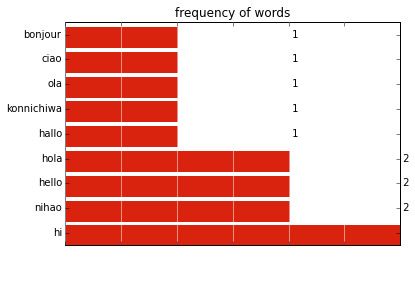

In [29]:
#modify the code to sort the word count records in decreasing order of frequency and plot

text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
     
wordCounts = counts.collect()
for v in counts.collect():
    print v
    
myBarPlot(wordCounts[:10], "frequency of words")



## Quiz: Part 2 Modify the code to produce a list of the 5 rarest words

(u'hallo', 1)
(u'konnichiwa', 1)
(u'ola', 1)
(u'ciao', 1)
(u'bonjour', 1)


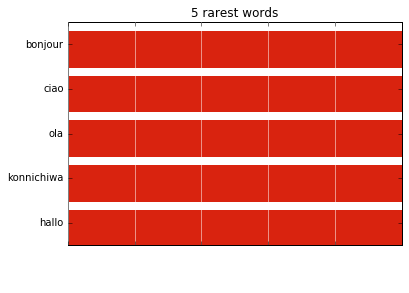

In [16]:
#  sort increasing L
logFileNAME = 'wordcount.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .map(lambda (a, b): (b, a)) \

    
myBarPlot(wordCounts, "5 rarest words")

## Secondary sort (Optional)
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Please refer to the total sort guide (in Labs-13-03-TotalSortGuide) for examples of secondary sorts in Spark. Please provide the following: all terms sorted in decreasing order of frequency with ties being sorted in alphabetical order.

# MLlib-centric KMeans


Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

# Homegrown KMeans versus MLLib 

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb). Cut and paste code segments from that notebook as needed below into this notebook.
## MLLib-based KMeans
Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



 ## KMeans Experiments via Homegrown kmeans

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb) 

Repeat the experiments in part one of this  Explain any differences between the results in HW3.3 and HW3.4. 

## Making Homegrown KMeans more efficient  
The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. Think about using the following: 

* broadcast variables: have a look [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)
* Use a combiner and MapPartitions. See this following figure for inspiration (where we are calculating the average length of a tweet):

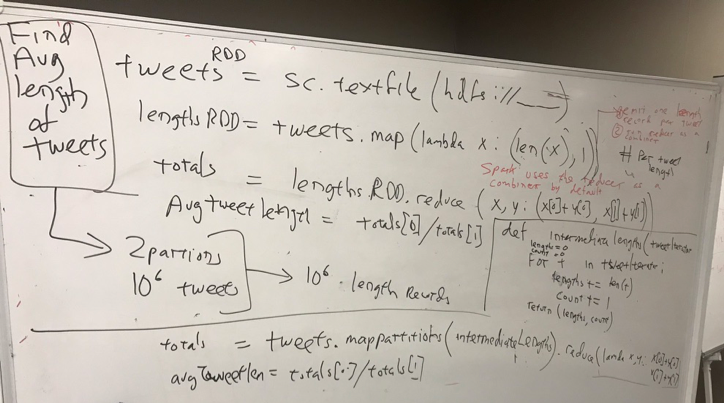

##  Gaussian Mixture models (Optional and a total stretch exercise)


Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it and implement a Gaussian Mixture Model and repeat the experiements in Part 1 of this question. Explain  any differences between the results in HW3.3 and HW3.5.1.


__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

# Linear Regression

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


## OPTIONAL Linear Regression

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

# Decision Trees for Classification (over discrete input variables)

- Loosely based on  from Chapter 17 of [Data Science From Scratch](https://www.safaribooksonline.com/library/view/data-science-from/9781491901410/) by Joel Grus   
- Code Source adopted from: https://github.com/joelgrus/data-science-from-scratch/blob/master/code/decision_trees.py

## Table of Contents <a name="TOC"></a> 

1.  [Introduction](#1)
2.  [Entropy](#2)
3.  [The Entropy of a Partition](#3)
4.  [Creating a Decision Tree](#4)   
5.  [Putting It All Together](#5)
6.  [Random Forests](#6)
7.  [For Further Exploration](#7)

## 1.  Introduction <a name="1"></a>
[Back to Table of Contents](#TOC)

"A decision tree uses a tree structure to represent a number of possible *decision paths* and an outcome for each path.

If you have ever played the game Twenty Questions, then it turns out you are familiar with decision trees.

<img src="https://dl.dropbox.com/s/huzi4ffo0ooxu32/DecisionTreeAnimal.png" width="600" height="600" />

Finding an 'optimal' decision tree for a set of training data is computationally a very hard problem. (We will get around this by trying to build a good-enough tree rather than an optimal one, although for large data sets this can still be alot of work.) More important, it is very easy (and very bad) to build decision trees that are *overfitted* to the training data, and that don’t generalize well to unseen data.

Most people divide decision trees into *classification trees* (which produce categorical outputs) and *regression trees* (which produce numeric outputs)."

## Entropy 
"In order to build a decision tree, we will need to decide what questions to ask and in what order. At each stage of the tree there are some possibilities we’ve eliminated and some that we haven’t. After learning that an animal doesn’t have more than five legs, we’ve eliminated the possibility that it’s a grasshopper. We haven’t eliminated the possibility that it’s a duck. Every possible question partitions the remaining possibilities according to their answers.  

Ideally, we’d like to choose questions whose answers give a lot of information about what our tree should predict. If there’s a single yes/no question for which 'yes' answers always correspond to True outputs and 'no' answers to False outputs (or vice versa), this would be an awesome question to pick. Conversely, a yes/no question for which neither answer gives you much new information about what the prediction should be is probably not a good choice.

We capture this notion of 'how much information' with *entropy*. You have probably heard this used to mean disorder. We use it to represent the uncertainty associated with data.

Imagine that we have a set $S$ of data, each member of which is labeled as belonging to one of a finite number of classes $C_1, \dots , C_n$. If all the data points belong to a single class, then there is no real uncertainty, which means we’d like there to be low entropy.  If the data points are evenly spread across the classes, there is a lot of uncertainty and we’d like there to be high entropy.  

In math terms, if $p_i$ is the proportion of data labeled as class $c_i$, we define the entropy as: 

\begin{equation}
H(S)=  −p_1 log_2(p_1) − \dots − p_n log_2(p_n)
\end{equation}

with the (standard) convention that $0 log 0 = 0$.

Without worrying too much about the grisly details, each term $−p_i log_2(p_i)$ is non-negative and is close to zero precisely when $p_i$ is either close to zero or close to one (Figure 17-2).

<img src="https://dl.dropbox.com/s/txnatys7w6u5mor/plogp.png" width="600" height="600" />

This means the entropy will be small when every $p_i$ is close to 0 or 1 (i.e., when most of the data is in a single class), and it will be larger when many of the $p_i$’s are not close to 0 (i.e., when the data is spread across multiple classes). This is exactly the behavior we desire.  It is easy enough to roll all of this into a function:

In [1]:
from __future__ import division
from collections import Counter, defaultdict
from functools import partial
import math, random

In [2]:
def entropy(class_probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

"Our data will consist of pairs (input, label), which means that we’ll need to compute the class probabilities ourselves. Observe that we don’t actually care which label is associated with each probability, only what the probabilities are:

In [3]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count/total_count for count in Counter(labels).values()]

def data_entropy(labeled_data):        
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

## The Entropy of a Partition 

"What we’ve done so far is compute the entropy (think 'uncertainty') of a single set of labeled data. Now, each stage of a decision tree involves asking a question whose answer partitions data into one or (hopefully) more subsets. For instance, our 'does it have more than five legs?' question partitions animals into those who have more than five legs (e.g., spiders) and those that don’t (e.g., echidnas).

Correspondingly, we’d like some notion of the entropy that results from partitioning a set of data in a certain way. We want a partition to have low entropy if it splits the data into subsets that themselves have low entropy (i.e., are highly certain), and high entropy if it contains subsets that (are large and) have high entropy (i.e., are highly uncertain).

For example, my 'Australian five-cent coin' question was pretty dumb (albeit pretty lucky!), as it partitioned the remaining animals at that point into $S_1$ = {echidna} and $S_2$ = {everything else}, where $S_2$ is both large and high-entropy. ($S_1$ has no entropy but it represents a small fraction of the remaining 'classes.')  

Mathematically, if we partition our data $S$ into subsets $S_1, \dots , S_m$ containing proportions $q_1, \dots , q_m$ of the data, then we compute the entropy of the partition as a weighted sum: 

\begin{equation}
H = q_1H(S_1) + \dots + q_mH(S_m)
\end{equation}

which we can implement as:

In [4]:
def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)    
    return sum(data_entropy(subset)*len(subset)/total_count for subset in subsets )

"One problem with this approach is that partitioning by an attribute with many different values will result in a very low entropy due to overfitting. For example, imagine you work for a bank and are trying to build a decision tree to predict which of your customers are likely to default on their mortgages, using some historical data as your training set. Imagine further that the data set contains each customer’s Social Security number. Partitioning on SSN will produce one-person subsets, each of which necessarily has zero entropy. But a model that relies on SSN is certain not to generalize beyond the training set. For this reason, you should probably try to avoid (or bucket, if appropriate) attributes with large numbers of possible values when creating decision trees."

## Creating a Decision Tree 

"The VP provides you with the interviewee data, consisting of (per your specification) pairs (input, label), where each input is a *dict* of candidate attributes, and each label is either True (the candidate interviewed well) or False (the candidate inter‐viewed poorly). In particular, you are provided with each candidate’s level, her preferred language, whether she is active on Twitter, and whether she has a PhD:

In [5]:
inputs = [
          ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
          ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
          ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
          ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
          ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
          ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
          ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
          ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
          ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
          ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
          ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
          ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
          ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
          ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
         ]

"Our tree will consist of *decision nodes* (which ask a question and direct us differently depending on the answer) and *leaf nodes* (which give us a prediction). We will build it using the relatively simple ID3 algorithm, which operates in the following manner.  Let’s say we’re given some labeled data, and a list of attributes to consider branching on.

- If the data all have the same label, then create a leaf node that predicts that label and then stop.
- If the list of attributes is empty (i.e., there are no more possible questions to ask), then create a leaf node that predicts the most common label and then stop.
- Otherwise, try partitioning the data by each of the attributes
- Choose the partition with the lowest partition entropy
- Add a decision node based on the chosen attribute
- Recur on each partitioned subset using the remaining attributes

This is what’s known as a 'greedy' algorithm because, at each step, it chooses the most immediately best option. Given a data set, there may be a better tree with a worse-looking first move. If so, this algorithm won’t find it. Nonetheless, it is relatively easy to understand and implement, which makes it a good place to begin exploring decision trees.

Let’s manually go through these steps on the interviewee data set. The data set has both `True` and `False` labels, and we have four attributes we can split on. So our first step will be to find the partition with the least entropy. We’ll start by writing a function that does the partitioning:

In [17]:
def group_by(items, key_fn):
    """returns a defaultdict(list), where each input item 
    is in the list whose key is key_fn(item)"""
    groups = defaultdict(list)
    for item in items:
        key = key_fn(item)
        groups[key].append(item)
    return groups
    
def partition_by(inputs, attribute):
    """returns a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)"""
    return group_by(inputs, lambda x: x[0][attribute]) 

"and one that uses it to compute entropy:

In [18]:
def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""        
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

"Then we just need to find the minimum-entropy partition for the whole data set:

In [19]:
for key in['level','lang','tweets','phd']:
    print key, partition_entropy_by(inputs, key)

level 0.693536138896
lang 0.860131712855
tweets 0.788450457308
phd 0.892158928262


> level 0.693536138896  
> lang 0.860131712855  
> tweets 0.788450457308  
> phd 0.892158928262  

"The lowest entropy comes from splitting on level, so we’ll need to make a subtree for each possible level value. Every Mid candidate is labeled True, which means that the Mid subtree is simply a leaf node predicting True. For Senior candidates, we have a mix of Trues and Falses, so we need to split again:

In [20]:
senior_inputs = [(input, label) for input, label in inputs if input["level"] == "Senior"]

for key in ['lang', 'tweets', 'phd']:
    print key, partition_entropy_by(senior_inputs, key)

lang 0.4
tweets 0.0
phd 0.950977500433


> lang 0.4  
> tweets 0.0  
> phd 0.950977500433 

"This shows us that our next split should be on tweets, which results in a zero-entropy partition. For these Senior-level candidates, 'yes' tweets always result in True while 'no' tweets always result in False.

Finally, if we do the same thing for the Junior candidates, we end up splitting on phd, after which we find that no PhD always results in True and PhD always results in False."

<img src="https://dl.dropbox.com/s/sglzar089hb5rfg/DecisionTreeHiring.png" width="600" height="600" />

## Putting It All Together 

"Now that we’ve seen how the algorithm works, we would like to implement it more generally. This means we need to decide how we want to represent trees. We’ll use pretty much the most lightweight representation possible. We define a *tree* to be one of the following:

- `True`
- `False`
- `a tuple (attribute, subtree_dict)`

Here `True` represents a leaf node that returns `True` for any input, `False` represents a leaf node that returns False for any input, and a tuple represents a decision node that, for any input, finds its `attribute` value, and classifies the input using the corresponding subtree.  With this representation, our hiring tree would look like:

`('level',  
  {'Junior':('phd',{'no':True,'yes':False}),  
   'Mid': True,  
   'Senior':('tweets',{'no':False,'yes':True})})`  

There’s still the question of what to do if we encounter an unexpected (or missing) attribute value. What should our hiring tree do if it encounters a candidate whose `level` is “Intern”? We’ll handle this case by adding a `None` key that just predicts the most common label. (Although this would be a bad idea if `None` is actually a value that appears in the data.)

Given such a representation, we can classify an input with:

In [21]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    
    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree
   
    # otherwise find the correct subtree
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree
    
    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input

"All that’s left is to build the tree representation from our training data:

In [22]:
def build_tree_id3(inputs, split_candidates=None):

    # if this is our first pass, 
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    if num_trues == 0:                  # if only Falses are left
        return False                    # return a "False" leaf
        
    if num_falses == 0:                 # if only Trues are left
        return True                     # return a "True" leaf

    if not split_candidates:            # if no split candidates left
        return num_trues >= num_falses  # return the majority leaf
                            
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
        key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates 
                      if a != best_attribute]
    
    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.iteritems() }

    subtrees[None] = num_trues > num_falses # default case

    return (best_attribute, subtrees)

print "building the tree"
tree = build_tree_id3(inputs)
print tree

building the tree
('level', {'Senior': ('tweets', {'yes': True, None: False, 'no': False}), None: True, 'Mid': True, 'Junior': ('phd', {'yes': False, None: True, 'no': True})})


"In the tree we built, every leaf consisted entirely of `True` inputs or entirely of `False` inputs. This means that the tree predicts perfectly on the training data set. But we can also apply it to new data that wasn’t in the training set:

In [23]:
print "Junior / Java / tweets / no phd: ", classify(tree, 
     {"level" : "Junior", 
      "lang" : "Java", 
      "tweets" : "yes", 
      "phd" : "no"}) 

print "Junior / Java / tweets / phd: ", classify(tree, 
    {"level" : "Junior", 
     "lang" : "Java", 
     "tweets" : "yes", 
     "phd" : "yes"})

Junior / Java / tweets / no phd:  True
Junior / Java / tweets / phd:  False


"And also to data with missing or unexpected values:

In [24]:
print "Intern: ", classify(tree, { "level" : "Intern" } )
print "Senior: ", classify(tree, { "level" : "Senior" } )

Intern:  True
Senior:  False


## Random Forests 

"Given how closely decision trees can fit themselves to their training data, it’s not surprising that they have a tendency to overfit. One way of avoiding this is a technique called *random forests*, in which we build multiple decision trees and let them vote on how to classify inputs:

In [25]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

"Our tree-building process was deterministic, so how do we get random trees?  One piece involves bootstrapping data (recall “Digression: The Bootstrap” on page183).  Rather than training each tree on all the inputs in the training set, we train each tree on the result of `bootstrap_sample(inputs)`. Since each tree is built using different data, each tree will be different from every other tree. (A side benefit is that it’s totally fair to use the nonsampled data to test each tree, which means you can get away with using all of your data as the training set if you are clever in how you measure performance.) This technique is known as *bootstrap aggregating* or *bagging*.  

A second source of randomness involves changing the way we chose the `best_attribute` to split on. Rather than looking at all the remaining attributes, we first choose a random subset of them and then split on whichever of those is best:

In [26]:
# # if there's already few enough split candidates, look at all of them
# if len(split_candidates) <= self.num_split_candidates:
#     sampled_split_candidates = split_candidates    
# # otherwise pick a random sample
# else:
#     sampled_split_candidates = random.sample(split_candidates, self.num_split_candidates)
    
# # now choose the best attribute only from those candidates
# best_attribute = min(sampled_split_candidates, key = partial(partition_entropy_by, inputs))

# partitions=partition_by(inputs, best_attribute)

"This is an example of a broader technique called *ensemble learning* in which we combine several weak learners (typically high-bias, low-variance models) in order to produce an overall strong model.

Random forests are one of the most popular and versatile models around.

##  For Further Exploration 

- scikit-learn has many [`Decision Tree`](http://bit.ly/1ycPmuq) models. It also has an [`ensemble`](http://bit.ly/1ycPom1) module that includes a `RandomForestClassifier` as well as other ensemble methods.
- We barely scratched the surface of decision trees and their algorithms. [Wikipedia](http://bit.ly/1ycPn1j) is a good starting point for broader exploration."

 <a name="4.1"></a>
#  Build a decision to predict whether you can play tennis or not

[Back to Table of Contents](#TOC)

Decision Trees

Write a program in Python (or in Spark; the Spark part is optional) to implement the ID3 decision tree algorithm. Have a look at this [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/p99ro9v9z81wtwh/Decision_Trees.ipynb)  for ideas. You should build a tree to predict PlayTennis, based on the other attributes (but, do not use the Day attribute in your tree.). You should read in a space delimited dataset in a file called dataset.txt and output to the screen your decision tree and the training set accuracy in some readable format. For example, here is the tennis dataset. The first line will contain the names of the fields:

<PRE>
Day outlook temperature humidity wind playtennis
d1 sunny hot high FALSE no
d2 sunny hot high TRUE no
d3 overcast hot high FALSE yes
d4 rainy mild high FALSE yes
d5 rainy cool normal FALSE yes
d6 rainy cool normal TRUE no
d6 overcast cool normal TRUE yes
d7 sunny mild high FALSE no
d8 sunny cool normal FALSE yes
d9 rainy mild normal FALSE yes
d10 sunny mild normal TRUE yes
d11 overcast mild high TRUE yes
d12 overcast hot normal FALSE yes
d12 rainy mild high TRUE no
</PRE>

The last column is the classification attribute, and will always contain contain the values yes or no.

For output, you can choose how to draw the tree so long as it is clear what the tree is. You might find it easier if you turn the decision tree on its side, and use indentation to show levels of the tree as it grows from the left. For example:

<PRE>
outlook = sunny
|  humidity = high: no
|  humidity = normal: yes
outlook = overcast: yes
outlook = rainy
|  windy = TRUE: no
|  windy = FALSE: yes

</PRE>

You don't need to make your tree output look exactly like above: feel free to print out something similarly readable if you think it is easier to code.

You may find Python dictionaries especially useful here, as they will give you a quick an easy way to help manage counting the number of times you see a particular attribute.

Here are some FAQs that I've gotten in the past regarding this assignment, and some I might get if I don't answer them now.

__Should my code work for other datasets besides the tennis dataset?__ 
Yes. We will give your program a different dataset to try it out with. You may assume that our dataset is correct and well-formatted, but you should not make assumptions regrading number of rows, number of columns, or values that will appear within. The last column will also be the classification, and will always contain yes or no values.

__Is it possible that some value, like "normal," could appear in more than one column?__
Yes. In addition to the column "humidity", we might have had another column called "skycolor" which could have values "normal," "weird," and "bizarre."

__Could "yes" and "no" appear as possible values in columns other than the classification column?__
Yes. In addition to the classification column "playtennis," we might have had another column called "seasonalweather" which would contain "yes" and "no."

## What is the classification accuracy of the tree on the training data?__


## puzzle
Is it possible to produce some set of correct training examples that will get the algorihtm
to include the attribute Temperature in the learned tree, even though the true target concept is
independent of Temperature? if no, explain. If yes, give such a set. __

## Build a tree
Now, build a tree using only examples D1–D7. What is the classification accuracy for the
training set? what is the accuracy for the test set (examples D8–D14)? explain why you think these
are the results.__

## another puzzle
In this case, and others, there are only a few labelled examples available for training (that
is, no additional data is available for testing or validation). Suggest a concrete pruning strategy, that
can be readily embedded in the algorithm, to avoid over fitting. Explain why you think this strategy
should work.__

## Regression Tree (OPTIONAL Homework) 


Implement a decision tree algorithm for regression for two input continous variables and one categorical input variable on a single core computer using Python. 

- Use the IRIS dataset to evaluate your code, where the input variables are: Petal.Length Petal.Width  Species  and the target or output variable is  Sepal.Length. 
- Use the same dataset to train and test your implementation. 
- Stop expanding nodes once you have less than ten (10) examples (along with the usual stopping criteria). 
- Report the mean squared error for your implementation and contrast that with the MSE from scikit-learn's implementation on this dataset (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)


 
## Predict survival on the Titanic using Python (Logistic regression, SVMs, Random Forests)


The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, you need to review (and edit the code) in this [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/kmbgrkhh73931lo/Titanic-EDA-LogisticRegression.ipynb) to do analysis of what sorts of people were likely to survive. In particular, please look at how the tools of machine learning are used to predict which passengers survived the tragedy. Please share any useful graphs/analysis you come up with via the group email. For example, pick the top two most important variables and plot the separating hyperplane in this 2D space that is generated using an SVM (or logistic regression model or plot both; are they similar?) that is learnt using those two features only. Comment on your observations. Please feel free to come up other graphs/analysis (e.g., clustering the passengers). 

For more details see:

* https://www.kaggle.com/c/titanic

## Do a Kaggle Submission to Predict survival on the Titanic using Python

[Back to Table of Contents](#TOC)


<img src="http://trevorstephens.com/images/2014-01-10-getting-started-with-r.png",width=600,height=600>

 The following  [Github repository](https://github.com/trevorstephens/titanic) contains a series of tutorials that focus on the Titanic dataset. It comes in five parts, all written in R:
 
* Part 1: Booting Up R
* Part 2: The Gender-Class Model
* Part 3: Decision Trees
* Part 4: Feature Engineering
* Part 5: Random Forests

This repository contains all code used associated with the following excellent tutorial:

* http://trevorstephens.com/post/72916401642/titanic-getting-started-with-r


Using this [python notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/zshj6zmo8q6ej85/Titanic-EDA-LogisticRegression.ipynb) as a starting point, perform the following  submissions (**in Python**) to Kaggle for the Titanic prediction problem and see where you come on the Kaggle dashboard. Please report you place/rank on the dashboard, accuracy along with a screen short of ranking in the Kaggle Dashboard:

* Model 0 Baseline submission (predict the majority class)
* Model 1: The Gender-Class Model: where majority class model is modified such that class prediction is set 1 for the subset of passengers where the variable “Sex” is equal to “female”.
* Model 2 decision descision tree with the following formula: Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked
* Model 3 Decision tree model with derived features using the following formula: 
  * (Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + Title + FamilySize + FamilyID)
  * Using the Title feature (extracted from Name feature)
  * and the Family ID feature
* Model 4: Random Forest using Python code that replicates the following:  

> set.seed(415)

> fit <- cforest(as.factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + Fare +
                                       Embarked + Title + FamilySize + FamilyID,
                 data = train, 
                 controls=cforest_unbiased(ntree=2000, mtry=3))




## Fill in the blanks in the following table and discussion.


The **best result (Accuracy ==)** was achieved by the XXX  model run on all XXX features. 

<table align="left">
<caption>Model Performance on Titanic survival classification problem:  Accuracy</caption>
<tr><td align="center">Model ID</td><td align="center">Description</td><td align="center">Accuracy</td><td align="center">Rank on Kaggle</td></tr>
<tr><td align="center">0</td><td align="center">Baseline</td><td align="center">XXXX</td><td align="center">XXXX</td></tr>
<tr><td align="center">1</td><td align="center">Baseline</td><td align="center">XXXX</td><td align="center">XXXX</td></tr>
<tr><td align="center">2</td><td align="center">Baseline</td><td align="center">XXXX</td><td align="center">XXXX</td></tr>
<tr><td align="center">3</td><td align="center">Baseline</td><td align="center">XXXX</td><td align="center">XXXX</td></tr>
<tr><td align="center">4</td><td align="center">Baseline</td><td align="center">XXXX</td><td align="center">XXXX</td></tr>
</table> 

 <a name="4.4"></a>

# Heritage Healthcare Prize (Predict # Days in Hospital next year)
## NOTE this optional but will be as a starting basis for your project!


1. Introduction 
Back to Table of Contents

The Heritage Health Prize (HHP) was a data science challenge sponsored by The Heritage Provider Network. It took place from April 4, 2011 to April 4, 2013. For information on the winning entries, please see here.

Please see the following notebooks for more background and candidate solutions


- Spark Map-Reduce + MMLlib solution (with optional extensions) See [Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/v52cxipe7yftf97/HeritageHealthPrizeUnitTestNotebook_Spark-Map-Reduce.ipynb)

- Spark SQL + MLLib solution (with optional extensions): [Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/s2wxg6g982oho5m/HeritageHealthPrizeUnitTestNotebook_SQL_FINAL.ipynb)


Please look at section 7 in both notebooks complete any one or more of the suggested next steps. E.g.,

* Please complete the EDA extensions using inspiration from the Titanic Notebook from above.
* __Complete Section 3.B: EDA-0. Gather information to see what transformations may need to be done on the data.__
Answer questions about each raw DataFrame. In general, is the data in good shape? For example, in each of the Target DataFrames (df_target_Y1, df_target_Y2, df_target_Y3), what values does DaysInHospital take on? Are they all integers? What values does ClaimsTruncated take on? Are they all integers? In the Claims DataFrame (df_claims), how many different ProviderIDs are there? How many different PrimaryConditionGroups are there? What are their values? What values can the CharlesonIndex take on? Are they integers? In the Drug Count DataFrame (df_drug_count), what values can DrugCount take on? Are they all integers? Given this information, what transformations are needed?

* __Complete Section 3.D: EDA-1. Create tables and graphs to display information about the transformed DataFrames. __
For inspiration, see the Titanic notebook discussed above. Answer questions about each DataFrame. For example, in each of the Target DataFrames (df_target_Y1, df_target_Y2, df_target_Y3), what is the minimum, maximum, mean, and standard deviation of DaysInHospital? In the Claims DataFrame, group by MemberID and Year and count the number of records. What is the minimum, maximum, mean, and standard deviation of the count? Do the same for the Drug Count and Lab Count DataFrames, etc.


* __ Please generate ensemble of DT model using 100 trees with 8 nodes and report the Loss __
Try additional models. See possibilities here (e.g. Decision Tree Regressor, Gradient-Boosted Trees Regressor, Random Forest Regressor). See an example here. Tune their hyperparameters. Try different feature selections. Try a two-step model.